In [7]:
import pandas as pd
import seaborn as sns
import pylab as plt
import pandas as pd
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait   # para esperar a que cargue
from selenium.webdriver.support import expected_conditions as EC   # condiciones esperadas
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By # By es para buscar por tag, clase, id...
import time
import requests
import warnings
from bs4 import BeautifulSoup
from tqdm import tqdm
warnings.filterwarnings('ignore')
from multiprocessing import Pool

In [8]:
data_gen = pd.read_csv('../data/NetflixOriginals.csv', encoding='utf-8', encoding_errors='ignore') #cargamos el archivo
data_cred = pd.read_csv('../data/credits.csv', encoding='utf-8', encoding_errors='ignore') 
data_titles = pd.read_csv('../data/titles.csv', encoding='utf-8', encoding_errors='ignore') 


In [3]:
#driver configuration
opciones=Options()

opciones.add_experimental_option('excludeSwitches', ['enable-automation'])
opciones.add_experimental_option('useAutomationExtension', False)
opciones.headless=False    # si True, no aperece la ventana (headless=no visible)
opciones.add_argument('--start-maximized')         # comienza maximizado
#opciones.add_argument('user-data-dir=selenium')    # mantiene las cookies
#opciones.add_extension('driver_folder/adblock.crx')       # adblocker
opciones.add_argument('--incognito')

# PATH = ChromeDriverManager().install()    # instala driver de chrome

# driver = webdriver.Chrome(PATH)      # abre una ventana de chrome

Extracción de datos

In [4]:

#proceso sobre cada película

url = 'https://www.imdb.com/title/tt1375666/reviews?ref_=tt_urv'
response = requests.get(url)

if response.status_code == 200:     #verificamos si la solicitud se ejecuta correctamente
    soup = BeautifulSoup(response.text, 'html.parser')      #creamos un objeto BeautifulSoup a partir del contenido HTML
    reviews = soup.find_all('div', {'class': 'text show-more__control'})        #buscamos los elementos sobre los que queremos iterar
    ratings = soup.find_all('span', {'class': 'rating-other-user-rating'})

    for i in range(len(reviews)):       #Iteramos sobre la lista de reseñas y calificaciones
        review_div = reviews[i].find_parent('div', {'class': 'lister-item-content'})
        review = review_div.find('a', {'class': 'title'}).text.strip() if review_div.find('a', {'class': 'title'}) else 'No title'
        rating = ratings[i].text.strip()
        print('Review:', review)
        print('Rating:', rating)
        print('------------------------------')
else:
    print('Error al enviar solicitud HTTP')






Review: A one-of-a-kind mind-blowing masterpiece!
Rating: 10/10
------------------------------
Review: Is it possible the makers understand how incredible this film is?
Rating: 10/10
------------------------------
Review: Answering all the questions with one answer: I feel guilt. ⭐
Rating: 10/10
------------------------------
Review: Inception was only less shocking to me than the Matrix
Rating: 10/10
------------------------------
Review: Insanely Brilliant ! Nolan has outdone himself !!
Rating: 10/10
------------------------------
Review: Didn't win Best Picture? WHAT?
Rating: 10/10
------------------------------
Review: In a Decade, "Inception" May Be A Religion
Rating: 10/10
------------------------------
Review: Amazingly original...but also a bit overwhelming.
Rating: 8/10
------------------------------
Review: Wait
Rating: 8/10
------------------------------
Review: Sci-fi perfection. A truly mesmerizing film.
Rating: 8/10
------------------------------
Review: My number one fav

In [8]:
# mergeamos el df de peliculas de netflix con el de peliculas de IMDB
# queremos obtener únicamente los datos de las películas de Netflix


data_gen = data_gen.rename(columns={'Title': 'title'})
data = pd.merge(data_gen, data_titles, on='title', how='left')      


In [35]:

#proceso sobre todas las películas

comentarios = {'imdb_id': [], 'comentarios': []}        #diccionario vacío donde almacenaremos los comentarios de las películas

for i in tqdm(range(len(data))):
    imdb_id = data.loc[i, 'imdb_id']        # Obtenemos el ID de la película
    if pd.isna(imdb_id):                    # Si el ID es nulo, saltamos a la siguiente fila
        print(f'IMDB ID nulo en fila {i}, saltando a la siguiente película')
        continue
    url = f'https://www.imdb.com/title/{imdb_id}/reviews?ref_=tt_ov_rt'     # Creamos la URL de los comentarios de la película usando su ID
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        reviews = soup.find_all('div', {'class': 'text show-more__control'})        #buscamos los elementos sobre los que queremos iterar
        ratings = soup.find_all('span', {'class': 'rating-other-user-rating'})
        comentarios_pelicula = {'imdb_id': imdb_id, 'comentarios': []}
        for i in range(len(reviews)):
            review_div = reviews[i].find_parent('div', {'class': 'lister-item-content'})        # Obtenemos comentarios y calificación
            review = review_div.find('a', {'class': 'title'}).text.strip() if review_div.find('a', {'class': 'title'}) else 'No title'
            rating = ratings[i].text.strip() if len(ratings) > i else 'Sin calificación'
            comentario = {'review': review, 'rating': rating}           #creamos un diccionario para almacenar comentario y calificación
            comentarios_pelicula['comentarios'].append(comentario)      #Añadimos el comentario al diccionario de comentarios
            comentarios['imdb_id'].append(imdb_id)
            comentarios['comentarios'].append(comentarios_pelicula)
            #print(f'Comentarios de película con IMDB ID {imdb_id} obtenidos')
    else:
        print(f'Error al obtener comentarios de la película con IMDB ID {imdb_id}')

df_comentarios = pd.DataFrame(comentarios)
df_comentarios.to_csv('comentarios_peliculas.csv', index=False)





  3%|▎         | 16/591 [00:38<27:28,  2.87s/it]

IMDB ID nulo en fila 16, saltando a la siguiente película
IMDB ID nulo en fila 17, saltando a la siguiente película


  3%|▎         | 19/591 [00:40<14:22,  1.51s/it]

IMDB ID nulo en fila 19, saltando a la siguiente película


  4%|▎         | 21/591 [00:42<12:31,  1.32s/it]

IMDB ID nulo en fila 21, saltando a la siguiente película


  4%|▍         | 26/591 [00:48<12:53,  1.37s/it]

IMDB ID nulo en fila 26, saltando a la siguiente película


  5%|▌         | 31/591 [00:53<10:19,  1.11s/it]

IMDB ID nulo en fila 31, saltando a la siguiente película


  6%|▌         | 34/591 [00:56<11:00,  1.19s/it]

IMDB ID nulo en fila 34, saltando a la siguiente película


  6%|▌         | 36/591 [00:58<09:45,  1.05s/it]

IMDB ID nulo en fila 36, saltando a la siguiente película


  7%|▋         | 41/591 [01:04<10:53,  1.19s/it]

IMDB ID nulo en fila 41, saltando a la siguiente película


  9%|▊         | 51/591 [01:15<10:24,  1.16s/it]

IMDB ID nulo en fila 51, saltando a la siguiente película


  9%|▉         | 55/591 [01:18<09:00,  1.01s/it]

IMDB ID nulo en fila 55, saltando a la siguiente película


 11%|█▏        | 67/591 [01:33<10:16,  1.18s/it]

IMDB ID nulo en fila 67, saltando a la siguiente película
IMDB ID nulo en fila 68, saltando a la siguiente película


 17%|█▋        | 100/591 [02:11<09:39,  1.18s/it]

IMDB ID nulo en fila 100, saltando a la siguiente película


 17%|█▋        | 102/591 [02:12<07:34,  1.08it/s]

IMDB ID nulo en fila 102, saltando a la siguiente película


 18%|█▊        | 107/591 [02:18<09:41,  1.20s/it]

IMDB ID nulo en fila 107, saltando a la siguiente película


 19%|█▉        | 113/591 [02:37<21:43,  2.73s/it]

IMDB ID nulo en fila 113, saltando a la siguiente película


 20%|█▉        | 118/591 [02:47<16:41,  2.12s/it]

IMDB ID nulo en fila 118, saltando a la siguiente película


 26%|██▌       | 154/591 [03:29<09:16,  1.27s/it]

IMDB ID nulo en fila 154, saltando a la siguiente película


 31%|███▏      | 185/591 [04:28<08:18,  1.23s/it]

IMDB ID nulo en fila 185, saltando a la siguiente película


 34%|███▍      | 200/591 [04:46<08:41,  1.33s/it]

IMDB ID nulo en fila 200, saltando a la siguiente película
IMDB ID nulo en fila 201, saltando a la siguiente película


 36%|███▌      | 212/591 [04:58<07:05,  1.12s/it]

IMDB ID nulo en fila 212, saltando a la siguiente película


 38%|███▊      | 227/591 [05:16<08:27,  1.39s/it]

IMDB ID nulo en fila 227, saltando a la siguiente película


 40%|███▉      | 235/591 [05:25<07:08,  1.20s/it]

IMDB ID nulo en fila 235, saltando a la siguiente película


 40%|████      | 239/591 [05:28<05:37,  1.04it/s]

IMDB ID nulo en fila 239, saltando a la siguiente película


 41%|████▏     | 244/591 [05:34<07:30,  1.30s/it]

IMDB ID nulo en fila 244, saltando a la siguiente película


 42%|████▏     | 247/591 [05:37<06:16,  1.09s/it]

IMDB ID nulo en fila 247, saltando a la siguiente película


 43%|████▎     | 256/591 [05:47<06:20,  1.14s/it]

IMDB ID nulo en fila 256, saltando a la siguiente película


 44%|████▎     | 258/591 [05:48<04:59,  1.11it/s]

IMDB ID nulo en fila 258, saltando a la siguiente película


 45%|████▍     | 263/591 [05:53<05:25,  1.01it/s]

IMDB ID nulo en fila 263, saltando a la siguiente película


 48%|████▊     | 282/591 [06:14<06:37,  1.29s/it]

IMDB ID nulo en fila 282, saltando a la siguiente película


 50%|█████     | 297/591 [06:31<05:56,  1.21s/it]

IMDB ID nulo en fila 297, saltando a la siguiente película


 51%|█████     | 299/591 [06:32<04:18,  1.13it/s]

IMDB ID nulo en fila 299, saltando a la siguiente película
IMDB ID nulo en fila 300, saltando a la siguiente película


 52%|█████▏    | 305/591 [06:36<03:54,  1.22it/s]

IMDB ID nulo en fila 305, saltando a la siguiente película


 52%|█████▏    | 307/591 [06:37<03:14,  1.46it/s]

IMDB ID nulo en fila 307, saltando a la siguiente película


 53%|█████▎    | 313/591 [06:43<04:32,  1.02it/s]

IMDB ID nulo en fila 313, saltando a la siguiente película


 55%|█████▍    | 324/591 [06:55<05:58,  1.34s/it]

IMDB ID nulo en fila 324, saltando a la siguiente película


 56%|█████▌    | 329/591 [06:59<04:19,  1.01it/s]

IMDB ID nulo en fila 329, saltando a la siguiente película
IMDB ID nulo en fila 330, saltando a la siguiente película


 59%|█████▉    | 350/591 [07:21<04:33,  1.13s/it]

IMDB ID nulo en fila 350, saltando a la siguiente película


 62%|██████▏   | 368/591 [07:45<04:55,  1.33s/it]

IMDB ID nulo en fila 368, saltando a la siguiente película


 63%|██████▎   | 375/591 [07:55<05:29,  1.52s/it]

IMDB ID nulo en fila 375, saltando a la siguiente película


 64%|██████▍   | 378/591 [07:58<04:43,  1.33s/it]

IMDB ID nulo en fila 378, saltando a la siguiente película


 64%|██████▍   | 380/591 [08:00<04:02,  1.15s/it]

IMDB ID nulo en fila 380, saltando a la siguiente película


 65%|██████▍   | 383/591 [08:03<03:47,  1.10s/it]

IMDB ID nulo en fila 383, saltando a la siguiente película


 65%|██████▌   | 385/591 [08:05<03:32,  1.03s/it]

IMDB ID nulo en fila 385, saltando a la siguiente película


 66%|██████▌   | 389/591 [08:10<03:55,  1.16s/it]

IMDB ID nulo en fila 389, saltando a la siguiente película


 67%|██████▋   | 395/591 [08:17<04:12,  1.29s/it]

IMDB ID nulo en fila 395, saltando a la siguiente película


 67%|██████▋   | 398/591 [08:20<03:26,  1.07s/it]

IMDB ID nulo en fila 398, saltando a la siguiente película
IMDB ID nulo en fila 399, saltando a la siguiente película


 68%|██████▊   | 403/591 [08:24<03:01,  1.03it/s]

IMDB ID nulo en fila 403, saltando a la siguiente película


 69%|██████▉   | 408/591 [08:28<02:59,  1.02it/s]

IMDB ID nulo en fila 408, saltando a la siguiente película


 71%|███████   | 421/591 [08:44<04:24,  1.56s/it]

IMDB ID nulo en fila 421, saltando a la siguiente película


 73%|███████▎  | 430/591 [08:53<03:23,  1.26s/it]

IMDB ID nulo en fila 430, saltando a la siguiente película


 74%|███████▍  | 440/591 [09:04<03:16,  1.30s/it]

IMDB ID nulo en fila 440, saltando a la siguiente película


 75%|███████▍  | 442/591 [09:06<02:29,  1.00s/it]

IMDB ID nulo en fila 442, saltando a la siguiente película


 75%|███████▌  | 445/591 [09:08<02:18,  1.05it/s]

IMDB ID nulo en fila 445, saltando a la siguiente película


 76%|███████▌  | 447/591 [09:10<02:13,  1.08it/s]

IMDB ID nulo en fila 447, saltando a la siguiente película


 77%|███████▋  | 457/591 [09:22<03:01,  1.35s/it]

IMDB ID nulo en fila 457, saltando a la siguiente película
IMDB ID nulo en fila 458, saltando a la siguiente película


 79%|███████▊  | 465/591 [09:28<01:56,  1.08it/s]

IMDB ID nulo en fila 465, saltando a la siguiente película


 81%|████████  | 477/591 [09:41<02:14,  1.18s/it]

IMDB ID nulo en fila 477, saltando a la siguiente película
IMDB ID nulo en fila 478, saltando a la siguiente película
IMDB ID nulo en fila 479, saltando a la siguiente película


 83%|████████▎ | 488/591 [09:51<01:53,  1.10s/it]

IMDB ID nulo en fila 488, saltando a la siguiente película


 84%|████████▍ | 496/591 [09:59<01:54,  1.21s/it]

IMDB ID nulo en fila 496, saltando a la siguiente película


 84%|████████▍ | 498/591 [10:00<01:26,  1.08it/s]

IMDB ID nulo en fila 498, saltando a la siguiente película


 85%|████████▍ | 502/591 [10:04<01:28,  1.01it/s]

IMDB ID nulo en fila 502, saltando a la siguiente película


 85%|████████▌ | 504/591 [10:06<01:13,  1.18it/s]

IMDB ID nulo en fila 504, saltando a la siguiente película


 86%|████████▌ | 507/591 [10:07<01:03,  1.32it/s]

IMDB ID nulo en fila 507, saltando a la siguiente película


 86%|████████▋ | 511/591 [10:11<01:12,  1.11it/s]

IMDB ID nulo en fila 511, saltando a la siguiente película
IMDB ID nulo en fila 512, saltando a la siguiente película


 88%|████████▊ | 519/591 [10:20<01:25,  1.19s/it]

IMDB ID nulo en fila 519, saltando a la siguiente película


 89%|████████▉ | 525/591 [10:27<01:24,  1.28s/it]

IMDB ID nulo en fila 525, saltando a la siguiente película


 89%|████████▉ | 527/591 [10:28<01:03,  1.00it/s]

IMDB ID nulo en fila 527, saltando a la siguiente película


 90%|████████▉ | 530/591 [10:30<00:54,  1.12it/s]

IMDB ID nulo en fila 530, saltando a la siguiente película


 90%|█████████ | 534/591 [10:34<00:54,  1.05it/s]

IMDB ID nulo en fila 534, saltando a la siguiente película
IMDB ID nulo en fila 535, saltando a la siguiente película


 91%|█████████ | 538/591 [10:36<00:38,  1.39it/s]

IMDB ID nulo en fila 538, saltando a la siguiente película
IMDB ID nulo en fila 539, saltando a la siguiente película


 92%|█████████▏| 542/591 [10:38<00:33,  1.48it/s]

IMDB ID nulo en fila 542, saltando a la siguiente película
IMDB ID nulo en fila 543, saltando a la siguiente película


 92%|█████████▏| 545/591 [10:39<00:27,  1.70it/s]

IMDB ID nulo en fila 545, saltando a la siguiente película


 93%|█████████▎| 547/591 [10:40<00:23,  1.87it/s]

IMDB ID nulo en fila 547, saltando a la siguiente película


 93%|█████████▎| 552/591 [10:45<00:35,  1.11it/s]

IMDB ID nulo en fila 552, saltando a la siguiente película


 95%|█████████▍| 561/591 [10:56<00:39,  1.32s/it]

IMDB ID nulo en fila 561, saltando a la siguiente película


 95%|█████████▌| 563/591 [10:58<00:28,  1.03s/it]

IMDB ID nulo en fila 563, saltando a la siguiente película


 96%|█████████▌| 567/591 [11:02<00:26,  1.11s/it]

IMDB ID nulo en fila 567, saltando a la siguiente película


 97%|█████████▋| 574/591 [11:09<00:20,  1.21s/it]

IMDB ID nulo en fila 574, saltando a la siguiente película
IMDB ID nulo en fila 575, saltando a la siguiente película


 98%|█████████▊| 579/591 [11:13<00:12,  1.05s/it]

IMDB ID nulo en fila 579, saltando a la siguiente película


 99%|█████████▊| 583/591 [11:16<00:08,  1.02s/it]

IMDB ID nulo en fila 583, saltando a la siguiente película
IMDB ID nulo en fila 584, saltando a la siguiente película
IMDB ID nulo en fila 585, saltando a la siguiente película


 99%|█████████▉| 588/591 [11:19<00:02,  1.45it/s]

IMDB ID nulo en fila 588, saltando a la siguiente película
IMDB ID nulo en fila 589, saltando a la siguiente película


100%|██████████| 591/591 [11:20<00:00,  1.15s/it]


In [60]:
IMDB_coment = pd.read_csv('comentarios_peliculas.csv', encoding='utf-8', encoding_errors='ignore') 


In [61]:
IMDB_coment.drop_duplicates(inplace=True)       #eliminamos las filas duplicadas

In [62]:
IMDB_coment.reset_index(drop=True, inplace=True)    #reteamos el indice



In [63]:
IMDB_coment.to_csv('../data/comentarios_clean.csv', index=False)
data.to_csv('../data/data_netflix.csv', index=False)

In [15]:
data.head()

,title,Genre,Premiere,Runtime,IMDB Score,Language,id,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Enter the Anime,Documentary,"August 5, 2019",58,2.5,English/Japanese,tm821164,MOVIE,What is anime? Through deep-dives with notable...,2019.0,NaN,58.0,['documentation'],"['US', 'JP']",NaN,tt10662450,2.6,1647.0,4.750,5.7
1,Dark Forces,Thriller,"August 21, 2020",81,2.6,Spanish,tm925785,MOVIE,"In search of his sister, a renegade criminal s...",2020.0,NaN,81.0,"['horror', 'thriller', 'action']",['MX'],NaN,tt12536776,2.7,597.0,4.030,4.3
2,The App,Science fiction/Drama,"December 26, 2019",79,2.6,Italian,tm847630,MOVIE,"Loving girlfriend, family fortune, breakout mo...",2019.0,NaN,79.0,"['drama', 'scifi', 'thriller']",['IT'],NaN,tt11385066,2.7,1347.0,7.473,2.9
3,The Open House,Horror thriller,"January 19, 2018",94,3.2,English,tm357820,MOVIE,A teenager and his mother find themselves besi...,2018.0,NaN,94.0,"['thriller', 'horror']",['US'],NaN,tt7608028,3.3,34156.0,13.150,3.7
4,Kaali Khuhi,Mystery,"October 30, 2020",90,3.4,Hindi,tm940566,MOVIE,When a restless spirit curses a Punjab village...,2020.0,NaN,90.0,"['thriller', 'horror', 'drama']",['IN'],NaN,tt10235600,3.5,1230.0,1.950,4.8


In [18]:
with open('../api_key.txt') as f:
    api_key = f.read().strip() # lee el contenido del archivo y elimina los espacios en blanco al principio y al final


search_url = 'https://api.themoviedb.org/3/search/movie'

# Cargar el DataFrame con el nombre de las películas
df = pd.read_csv('../data/data_netflix.csv')

# Recorrer cada fila del DataFrame y obtener los detalles completos de la película
genres = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    # Hacer una solicitud GET para buscar la película por nombre
    params = {'api_key': api_key, 'query': row['title']}
    response = requests.get(search_url, params=params)
    movies = response.json()['results']
    
    if len(movies) > 0:
        # Si se encontró la película, obtener sus detalles completos
        movie_id = movies[0]['id']
        movie_details_url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}'
        movie_details_response = requests.get(movie_details_url)
        movie_details = movie_details_response.json()
        genre_names = [genre['name'] for genre in movie_details['genres']]
        genres.append(', '.join(genre_names))
    else:
        # Si no se encontró la película, agregar un valor nulo
        genres.append(None)

# Agregar una nueva columna al DataFrame con los géneros de cada película
df['generos'] = genres

# Guardar el DataFrame actualizado en un nuevo archivo CSV
#df.to_csv('data_netflix.csv', index=False)



100%|██████████| 591/591 [02:01<00:00,  4.87it/s]


In [22]:
# Guardar el DataFrame actualizado en un nuevo archivo CSV
df.to_csv('../data/df_netflix.csv', index=False)

Limpieza de datos

In [25]:
#borramos algunas columnas que se han duplicado con el merge de Netflix e IMDB
df.drop(['Genre', 'runtime','imdb_score', 'genres', 'release_year', 'production_countries', 'seasons'], axis=1, inplace=True)


In [27]:
#renombramos las columnas
df = df.rename(columns={'title': 'Title','IMDB Score	': 'IMDB_score', 'id': 'Id', 'type': 'Type', 'description': 'Description', 'age_certification': 'Age_certification', 'imdb_id': 'IMDB_id', 'imdb_votes': 'IMDB_votes', 'tmdb_popularity': 'TMDB_popularity', 'tmdb_score': 'TMDB_score', 'generos': 'Genres'})

In [35]:
df = df.rename(columns={'TMDB_popularity':'TMDB_votes'})

In [37]:
#ordenamos las columnas
df = df.reindex(columns=['Film_id','Title', 'Premiere', 'Runtime', 'Genres', 'Language', 'Type', 'Description', 'Age_certification', 'IMDB_id', 'IMDB_score', 'IMDB_votes', 'TMDB_score', 'TMDB_votes'])


In [55]:
nan_cols = df.isna().mean() * 100  # porcentaje de nulos de la tabla Titles
nan_cols[nan_cols>0]

Age_certification    64.908722
IMDB_votes            1.014199
TMDB_score            0.405680
dtype: float64

<Axes: >

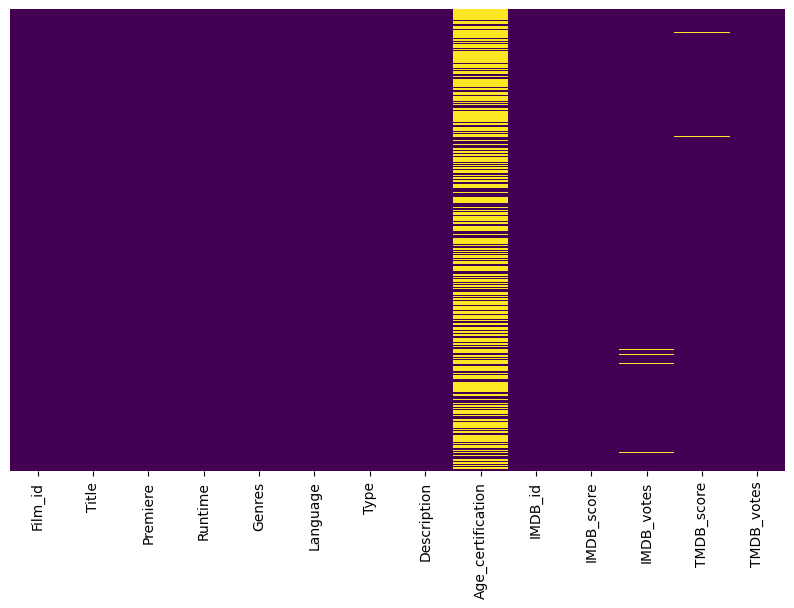

In [66]:
plt.figure(figsize=(10, 6))

sns.heatmap(df.isna(),    
                yticklabels=False,  
                cmap='viridis',     
                cbar=False,         
               )

In [48]:
df.dropna(subset=['Film_id', 'IMDB_id'], inplace=True)  #he observado que hay un 10% de filas que tienen todos los valores nulos
                                             #Tras valorar la importancia de estas filas y la información que ofrecían, así como la difultad para rellenarlas, he tomado la decisión de eliminarlas


In [52]:
df.Genres.value_counts()

Genres
Documentary                                      79
Drama                                            43
Comedy                                           35
Comedy, Romance                                  21
Romance, Comedy                                  19
                                                 ..
Romance, Comedy, Family                           1
Drama, Crime, Mystery, Thriller                   1
Thriller, Mystery, Horror                         1
Romance, TV Movie                                 1
Animation, Family, Adventure, Comedy, Fantasy     1
Name: count, Length: 191, dtype: int64

In [64]:
df['Age_certification'] = df['Age_certification'].str.lower()

# Para rellenar los valores nulos de la columna Age_certification, cada vez que haya un nulo, si pertenece a los siguientes géneros se asumirá que la certificación de edad es R (+17)
def fill_age_null(row):
    if pd.isna(row['Age_certification']):
        if 'thriller' in row['Genres'] or 'horror' in row['Genres'] or 'black comedy' in row['Genres']:
            return 'R'
    return row['Age_certification']

df['Age_certification'] = df.apply(lambda row: fill_age_null(row), axis=1)



In [67]:
df['Age_certification'] = df['Age_certification'].fillna('UNKNOWN')

In [68]:
df.dropna(subset=['IMDB_votes', 'TMDB_score'], inplace=True)  # eliminos las filas en las que los valores de estas columnas, ya que representan un 1% del total

In [73]:
# Guardar el DataFrame actualizado en un nuevo archivo CSV
df.to_csv('../data/df_netflix_clean.csv', index=False)

In [3]:
#creamos una columna Id autonumerica para poder realizar las relaciones posteriormente
data_cred.reset_index(inplace=True, drop=False)
data_cred.rename(columns={'index': 'Id'}, inplace=True)


In [4]:
data_cred = data_cred.rename(columns={'person_id':'Actor_id','id':'Film_id','name':'Name','character':'Character','role':'Role'})

In [6]:
df_destino = pd.DataFrame(columns=['Nombre'])
df_actor = pd.concat([data_cred[['Actor_id','Name']], df_destino], axis=1)


In [7]:
df_actor.drop(['Nombre'], axis=1, inplace=True)

In [8]:
data_cred.drop(['Name'], axis=1, inplace=True)

In [15]:
df_actor.head()

,Actor_id,Name
0,3748,Robert De Niro
1,14658,Jodie Foster
2,7064,Albert Brooks
3,3739,Harvey Keitel
4,48933,Cybill Shepherd


In [19]:
nan_cols = df_actor.isna().mean() * 100  # porcentaje de nulos de la tabla Titles
nan_cols[nan_cols>0]

Series([], dtype: float64)

In [10]:
df_actor.to_csv('../data/Actor_clean.csv', index=False)

In [13]:
#comprobamos que hay un 10% de personajes nulos, los rellenamos con 'unknown'
data_cred['Character'] = data_cred['Character'].fillna('unknown')

In [18]:
data_cred.head()

,Id,Actor_id,Film_id,Character,Role
0,0,3748,tm84618,Travis Bickle,ACTOR
1,1,14658,tm84618,Iris Steensma,ACTOR
2,2,7064,tm84618,Tom,ACTOR
3,3,3739,tm84618,Matthew 'Sport' Higgins,ACTOR
4,4,48933,tm84618,Betsy,ACTOR


In [19]:
data_cred.to_csv('../data/Reparto_clean.csv', index=False)

In [12]:
review = pd.read_csv('../data/comentarios_clean.csv', encoding='utf-8', encoding_errors='ignore') 

In [13]:
#creamos columna id autonumerico
review.reset_index(inplace=True, drop=False)
review.rename(columns={'index': 'Id'}, inplace=True)


In [15]:
review = review.rename(columns={'Id':'Review_id', 'imdb_id':'Film_id', 'comentarios':'Comment'})

In [16]:
review

,Review_id,Film_id,Comment
0,0,tt10662450,"{'imdb_id': 'tt10662450', 'comentarios': [{'re..."
1,1,tt12536776,"{'imdb_id': 'tt12536776', 'comentarios': [{'re..."
2,2,tt11385066,"{'imdb_id': 'tt11385066', 'comentarios': [{'re..."
3,3,tt7608028,"{'imdb_id': 'tt7608028', 'comentarios': [{'rev..."
4,4,tt10235600,"{'imdb_id': 'tt10235600', 'comentarios': [{'re..."
...,...,...,...
477,477,tt14152756,"{'imdb_id': 'tt14152756', 'comentarios': [{'re..."
478,478,tt13206564,"{'imdb_id': 'tt13206564', 'comentarios': [{'re..."
479,479,tt9426852,"{'imdb_id': 'tt9426852', 'comentarios': [{'rev..."
480,480,tt4908644,"{'imdb_id': 'tt4908644', 'comentarios': [{'rev..."


In [17]:
review.to_csv('../data/Review_clean.csv', index=False)

In [5]:
import csv

with open('../data/comentarios_clean2.csv') as archivo_csv:
    lector_csv = csv.reader(archivo_csv)
    for fila in lector_csv:
        datos = eval(fila[0])
        imdb_id = datos['imdb_id']
        comentarios = datos['comentarios']
        
        # Iterar sobre cada comentario y eliminar las comillas simples
        for comentario in comentarios:
            review = comentario['review'].replace("'", "")
            rating = comentario['rating'].replace("'", "")
            comentario['review'] = review
            comentario['rating'] = rating
        
        # Realizar operaciones con los datos



SyntaxError: invalid syntax (<string>, line 1)